In [4]:
import os.path

from charcoal import utils
import collections

import plotly.graph_objects as go

In [5]:
def make_hitlist_data(hit_list_filename, omit_genus=True, num=10):
    hits = utils.HitList(hit_list_filename)
    
    endings = '.fna.gz', 'fa.gz', '.fa', '_genomic'
    
    # sort by sum of bad bp at specific rank
    if omit_genus:
        sort_by = 'family_bad_bp'
    else:
        sort_by = 'genus_bad_bp'
    
    # pick off the top num items, sorted by given sort_by
    items = list(hits.rows.items())
    items.sort(key=lambda item: -int(item[1][sort_by]))
    items = items[:num]
    items.reverse()
    
    hitlist_data = collections.defaultdict(list)
    names = hitlist_data['names']
    
    # for each item, retrieve all tax rank bp values
    for name, row in items:
        # clean up names:
        for end in endings:
            if name.endswith(end): name = name[:-len(end)]
        names.append(name)

        last_bp = 0
        for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
            bp = row[f'{key}_bad_bp']
            bp = int(bp)
            values = hitlist_data[key]
            values.append(bp - last_bp)
            last_bp = bp
            
    return hitlist_data

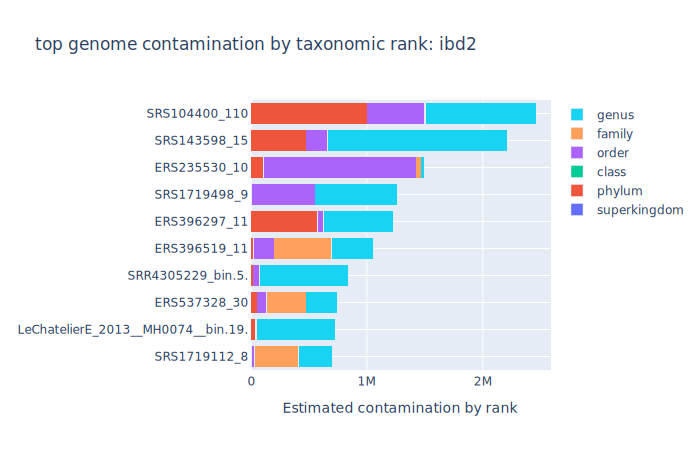

In [10]:
def plot_hitlist(hit_list_filename, omit_genus=True, num=10):
    hitlist_data = make_hitlist_data(hit_list_filename, omit_genus, num)
    
    names = hitlist_data['names']

    barchart_objs = []
    for key in 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus':
        values = hitlist_data[key]
        if omit_genus and key == 'genus': break
            
        bc_obj = go.Bar(name=key, y=names, x=values, orientation='h')
        barchart_objs.append(bc_obj)
        
    fig = go.Figure(data=barchart_objs)
    title = f'top genome contamination by taxonomic rank: {os.path.dirname(hit_list_filename)[7:]}'
    fig.update_layout(barmode='stack', template='plotly',
                      xaxis_title='Estimated contamination by rank',
                      title=title)

    return fig

fig = plot_hitlist('output.ibd2/hit_list_for_filtering.csv', omit_genus=False)
fig.show('svg')

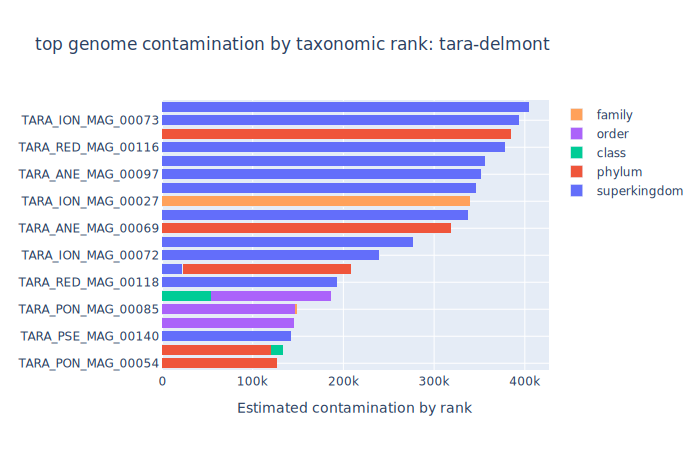

In [11]:
fig = plot_hitlist('output.tara-delmont/hit_list_for_filtering.csv', num=20)
fig.show('svg')

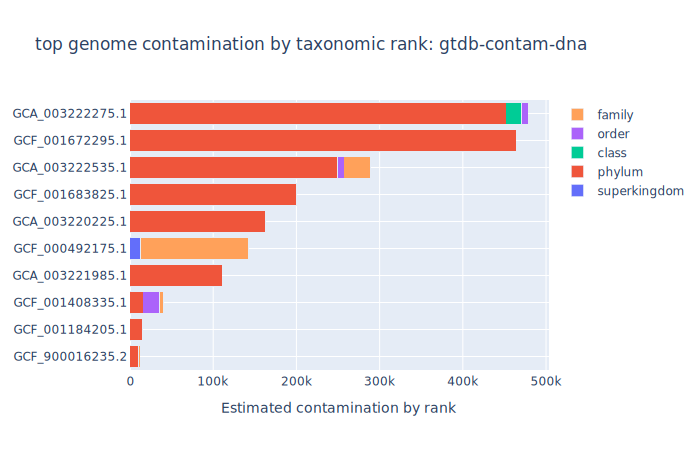

In [12]:
fig = plot_hitlist('output.gtdb-contam-dna/hit_list_for_filtering.csv')
fig.show('svg')